In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

In [44]:
data_df = pd.read_excel("../data/credit_card.xls", header=1)
data_df.rename(columns = {"PAY_0":'PAY_1',
                          "default payment next month" : "default"},
                           inplace = True)
data_df = data_df.drop("ID", axis=1)
data_df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [45]:
1 - np.mean(data_df["default"])

0.7787999999999999

In [46]:
data_df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

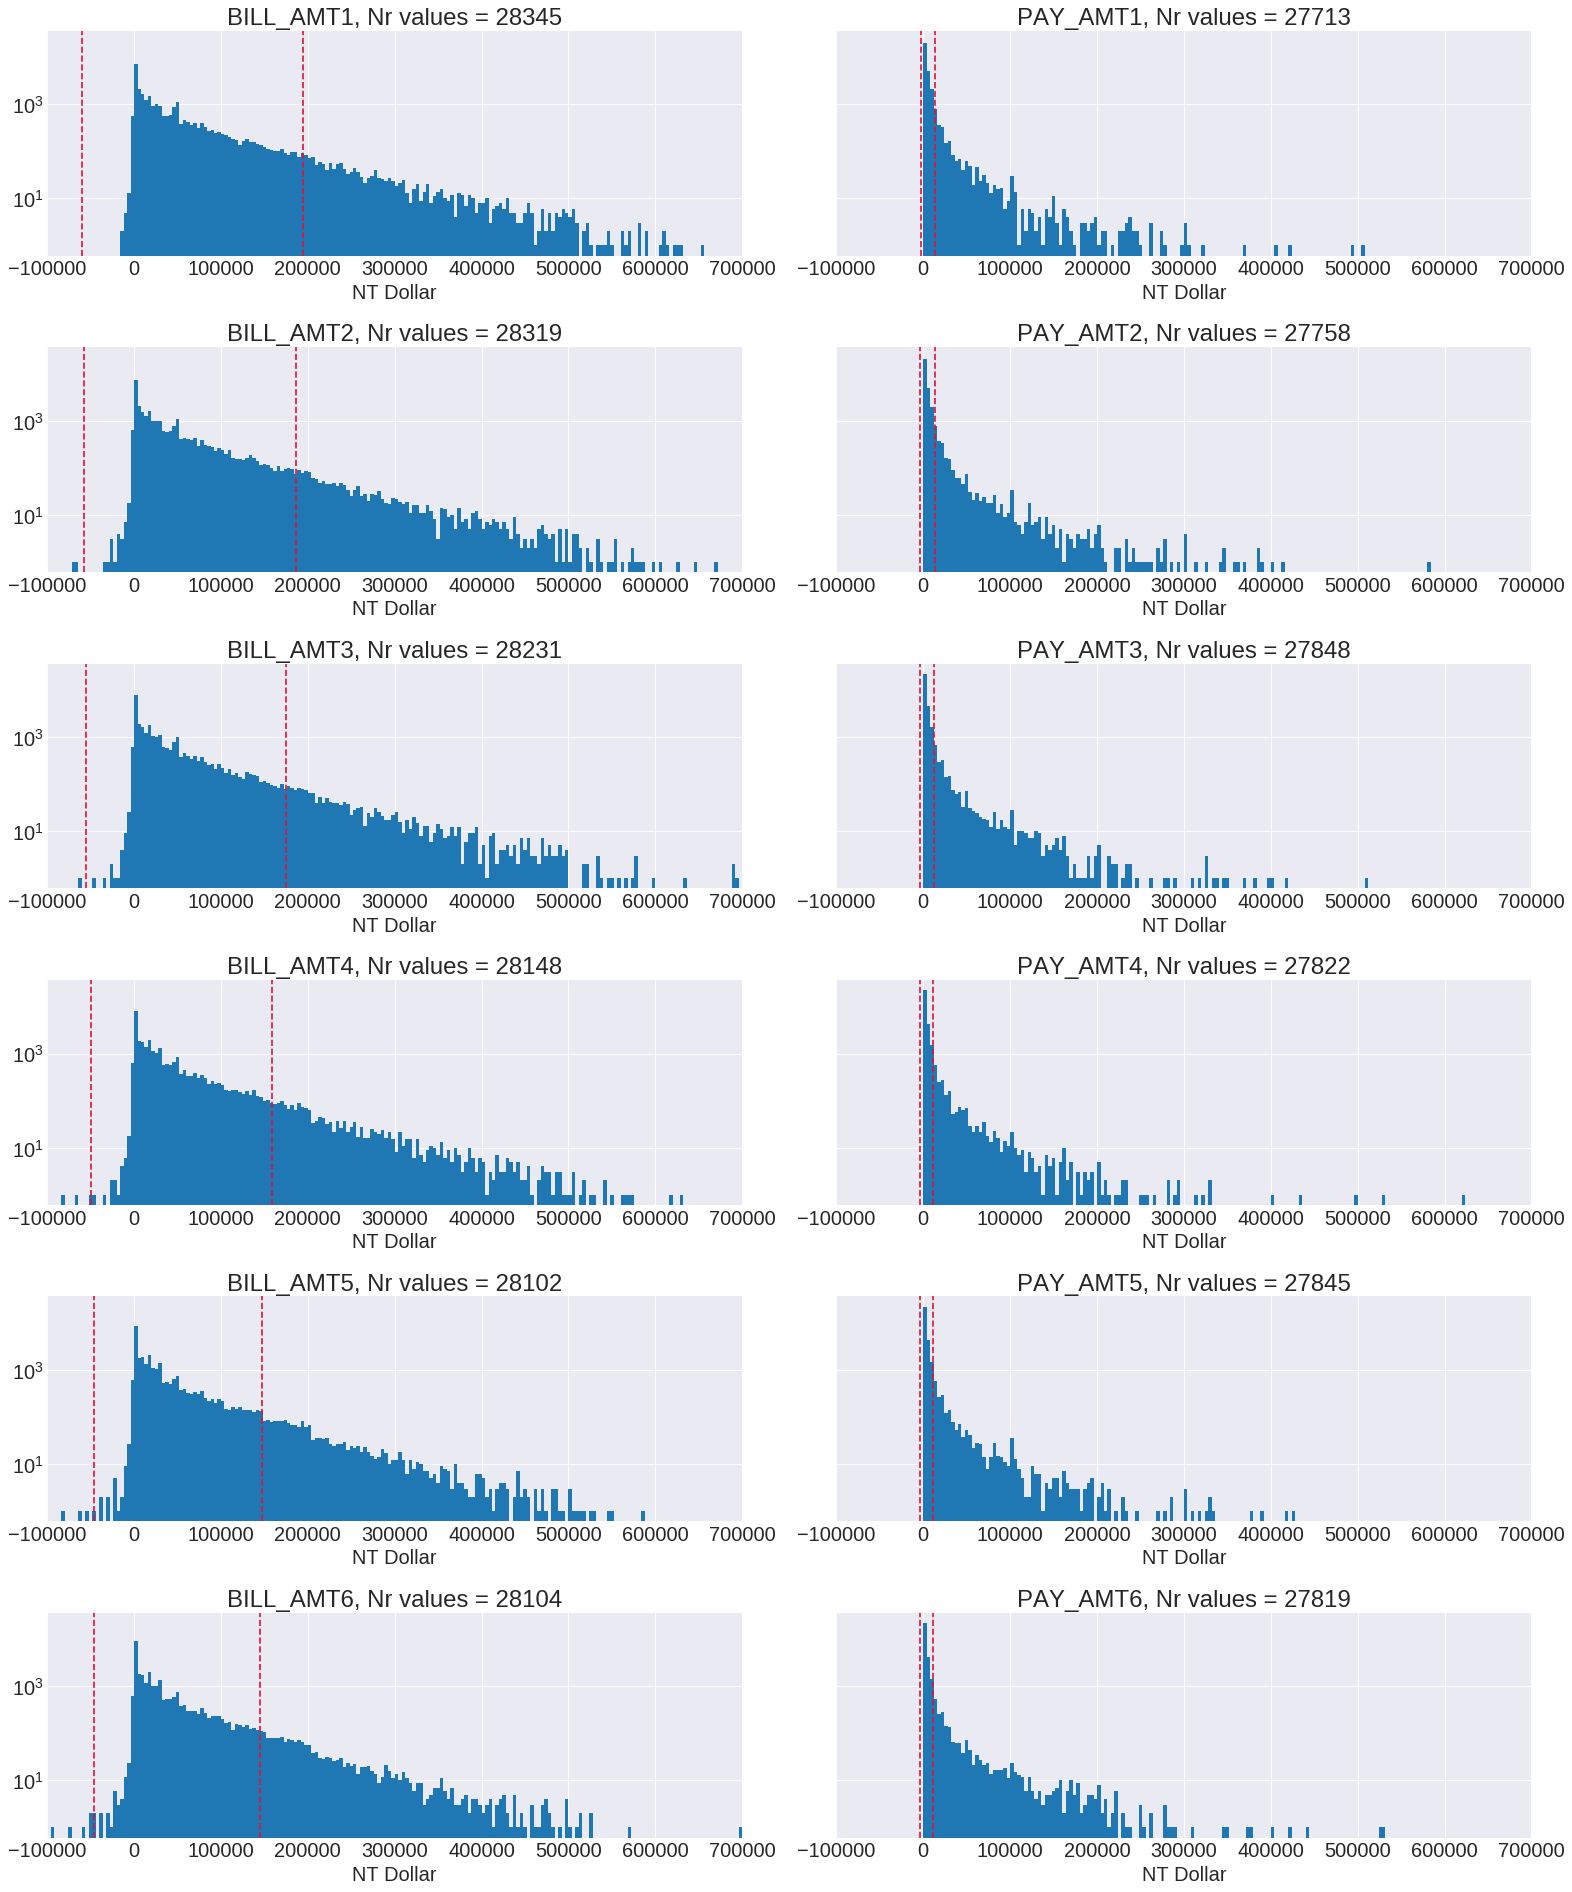

In [50]:
cut_indexes = np.ones(len(data_df), dtype=bool)
fig, ax = plt.subplots(6, 2, figsize=(20, 24), sharey=True)
for j, datatype in enumerate(["BILL_AMT", "PAY_AMT"]):
    for i in range(1, 7):        
        current_cut_indexes = np.ones(len(data_df), dtype=bool)

        dataname = datatype + str(i)
        xlim = (int(-1e5), int(7e5))
        
        Q1 = np.quantile(data_df[dataname], 0.25)
        Q3 = np.quantile(data_df[dataname], 0.75)
        IQR = Q3 - Q1
        current_cut_indexes = (data_df[dataname] < Q3 + 2.0*IQR)&(data_df[dataname] > Q1 - 1.0*IQR)

        ax[(i-1), j].hist(data_df[dataname], bins=200, log=True, range=xlim)
        ax[(i-1), j].axvline(x = Q1-1.0*IQR, c="crimson", ls="--")
        ax[(i-1), j].axvline(x = Q3+2.0*IQR, c="crimson", ls="--")
        ax[(i-1), j].set_title(f"{datatype + str(i)}, Nr values = {np.sum(current_cut_indexes)}")
        ax[(i-1), j].set_xlabel("NT Dollar")
        ax[(i-1), j].set_xlim(xlim)
        
        cut_indexes = cut_indexes&current_cut_indexes
plt.tight_layout()
plt.savefig(f"../figs/CC_IQR_cuts_BILL_PAY.pdf", bbox_inches="tight")

21308

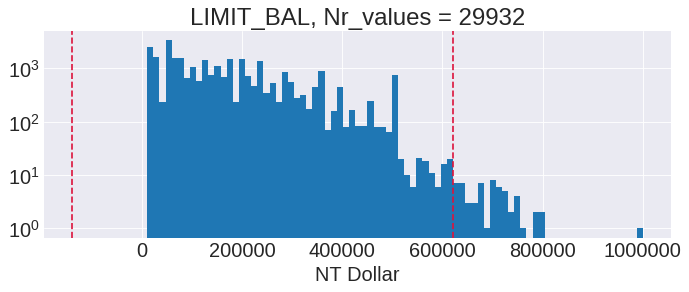

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharey=True)
Q1 = np.quantile(data_df["LIMIT_BAL"], 0.25)
Q3 = np.quantile(data_df["LIMIT_BAL"], 0.75)
IQR = Q3 - Q1
current_cut_indexes = (data_df["LIMIT_BAL"] < Q3 + 2.0*IQR) & (data_df["LIMIT_BAL"] > Q1 - 1.0*IQR)
cut_indexes = cut_indexes&current_cut_indexes
ax.hist(data_df["LIMIT_BAL"], bins="auto", log=True)
ax.axvline(Q1-1.0*IQR, ls="--", c="crimson")
ax.axvline(Q3+2.0*IQR, ls="--", c="crimson")
ax.set_title(f"LIMIT_BAL, Nr_values = {np.sum(current_cut_indexes)}")
ax.set_xlabel("NT Dollar")
plt.tight_layout()
plt.savefig("../figs/CC_IQR_cuts_LIMIT_BAL.pdf", bbox_inches="tight")
np.sum(cut_indexes)

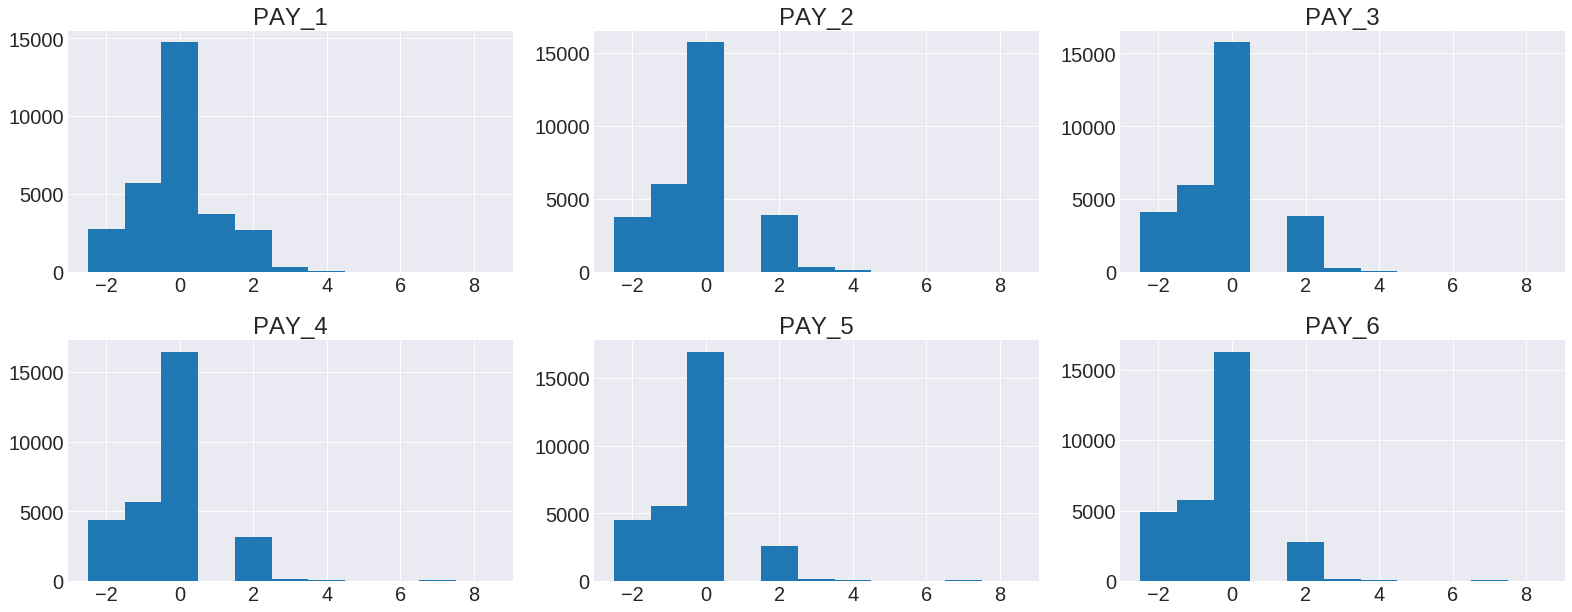

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
for i in range(6):
    ax[i//3, i%3].hist(data_df[f"PAY_{i+1}"], bins=np.arange(-2.5, 9.5))
    ax[i//3, i%3].set_title(f"PAY_{i+1}")
plt.tight_layout()
plt.savefig("../figs/CC_PAY_hist.pdf", bbox_inches="tight")

In [30]:
asdf1 = 0; asdf2 = 0
for i in range(1, 7):
    asdf1 += np.sum(data_df[f"PAY_{i}"] == 0)
for i in range(1, 7):
    asdf2 += np.sum(data_df[f"PAY_{i}"] == -2)
asdf3 = np.zeros(len(data_df), dtype=bool)
for i in range(1, 7):
    asdf3 = asdf3 | (data_df[f"PAY_{i}"] == -2) | (data_df[f"PAY_{i}"] == 0)

asdf1/len(data_df)/6, asdf2/len(data_df)/6, np.sum(asdf3)/len(data_df)

(0.5328833333333333, 0.1356388888888889, 0.8646333333333334)

In [31]:
data_df = data_df[cut_indexes]
data_df = data_df.reset_index(drop=True)

In [32]:
data_df[data_df == -2] = 0

In [33]:
data_df.to_pickle("../data/credit_card_cleaned.pickle")

In [34]:
1 - np.mean(data_df["default"])

0.7482635629810399

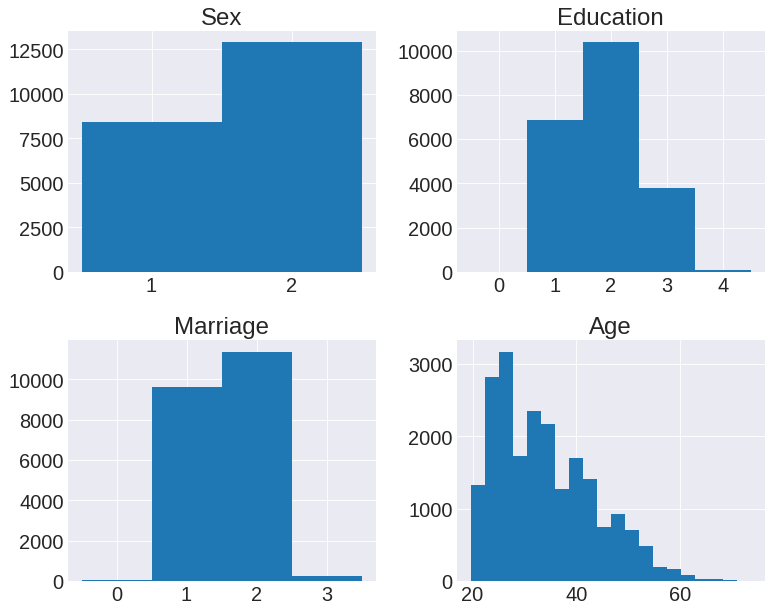

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].hist(data_df["SEX"], bins=np.arange(0.5, 3), align="mid")
ax[0,1].hist(data_df["EDUCATION"], bins=np.arange(-0.5, 5), align="mid")
ax[1,0].hist(data_df["MARRIAGE"], bins=np.arange(-0.5, 4), align="mid")
ax[1,1].hist(data_df["AGE"], bins=20, align="left");

ax[0,0].set_title("Sex")
ax[0,1].set_title("Education")
ax[1,0].set_title("Marriage")
ax[1,1].set_title("Age")

ax[0,0].set_xticks([1, 2])# ax[0,0].set_xticklabels(["Male", "Female"])
ax[0,1].set_xticks([0, 1, 2, 3, 4])#, ax[0,1].set_xticklabels(["NULL", "Grad School", "University", "High School", "Other"], rotation=45);
ax[1,0].set_xticks([0, 1, 2, 3]);
plt.tight_layout()
plt.savefig("../figs/CC_params_hist.pdf", bbox_inches="tight")

In [37]:
params_reduced = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_1", "BILL_AMT1", "PAY_AMT1", "default"]
params_pay = [f"PAY_{i}" for i in range(1, 7)]
params_pay.append("default")
data_df_reduced = data_df[params_reduced]
data_df_pay = data_df[params_pay]

In [38]:
corr_red = data_df_reduced.corr()[::-1]
corr_pay = data_df_pay.corr()[::-1]
corr = data_df.corr()[::-1]

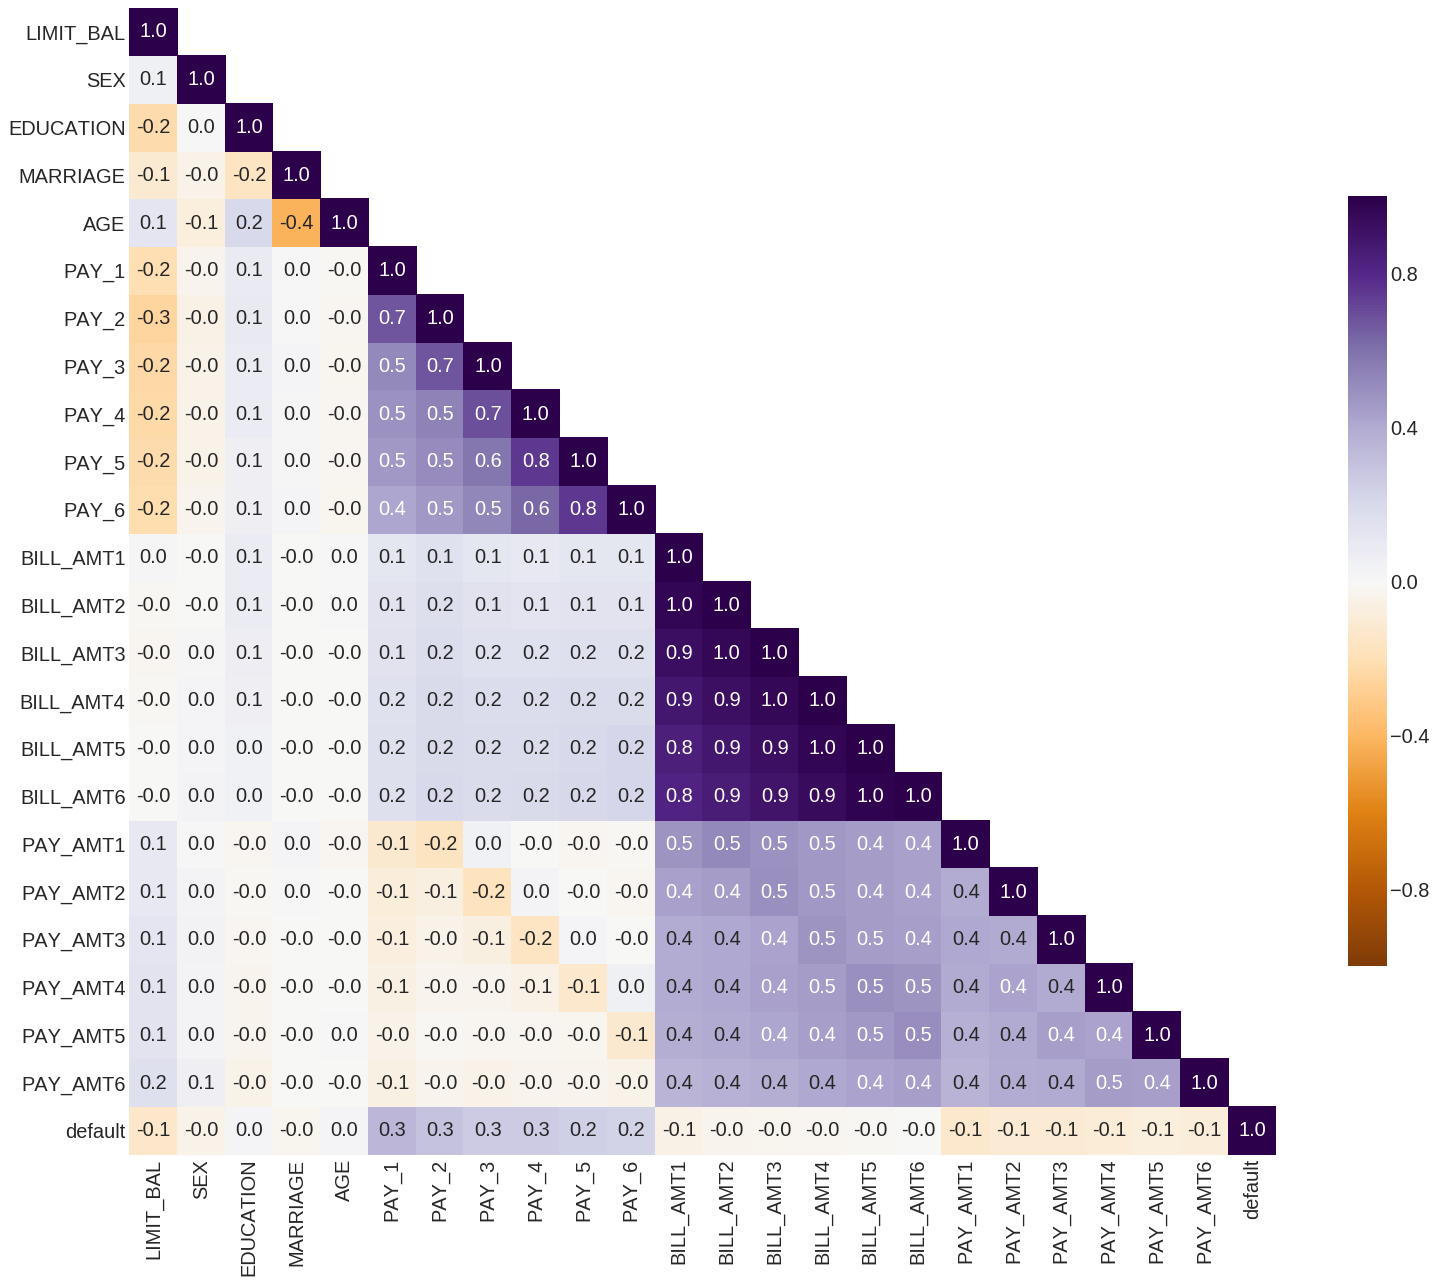

In [39]:
with sns.axes_style("white"):
    plt.figure(figsize=(20,20))
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True
    sns.heatmap(corr, mask=mask[::-1], annot=True, fmt=".1f", cmap="PuOr", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .5})
    plt.ylim(0.0, 24.0);
    plt.tight_layout();
    plt.savefig("../figs/CC_corr_all.pdf", bbox_inches="tight")

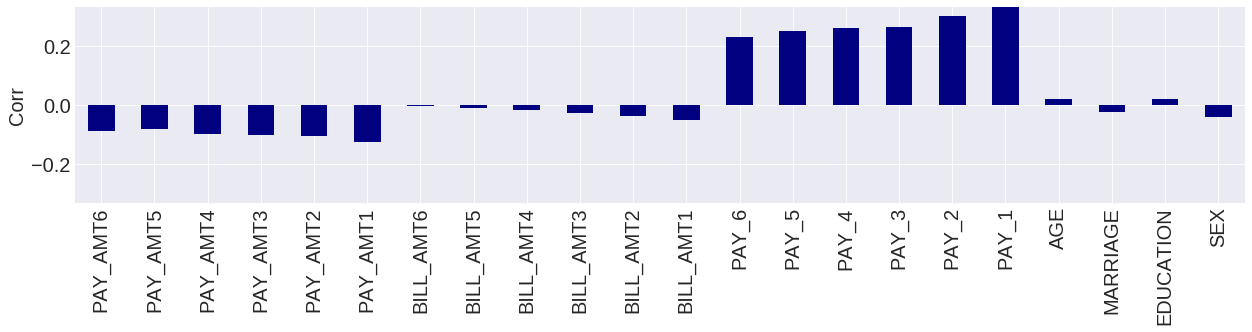

In [40]:
plt.figure(figsize=(16,4.5))
corr["default"].iloc[1:-1].plot.bar(color="navy");
plt.ylabel("Corr");
plt.tight_layout();
plt.ylim(-0.33, 0.33)
plt.savefig("../figs/CC_corr_bars.pdf", bbox_inches="tight");